# 1、数据分析

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
import pandas as pd
def read_dataset(fname):
    #指定第一列作为行索引
    data = pd.read_csv(fname,index_col=0)
    #丢弃无用的数据
    data.drop(['Name','Ticket','Cabin'],axis=1,inplace=True)
    #处理性别数据
    data['Sex']=(data['Sex']=='male').astype('int')
    #处理登船港口数据
    labels = data['Embarked'].unique().tolist()
    data['Embarked'] = data['Embarked'].apply(lambda n: labels.index(n))
    #处理缺失数据
    data = data.fillna(0)
    return data

train = read_dataset('./titanic/train.csv')

# 2、模型训练

In [5]:
from sklearn.model_selection import train_test_split

y = train['Survived'].values
X = train.drop(['Survived'],axis=1).values

X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.2)

print('train dataset:{0}; test dataset:{1}'.format(X_train.shape,X_test.shape))

train dataset:(712, 7); test dataset:(179, 7)


In [6]:
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier()
clf.fit(X_train,y_train)
train_score=clf.score(X_train,y_train)
test_score =clf.score(X_test, y_test)
print('train score:{0};test score:{1}'.format(train_score, test_score))

train score:0.9859550561797753;test score:0.7988826815642458


# 3、优化模型参数

In [7]:
# 参数选择 max_depth
def cv_score(d):
    clf = DecisionTreeClassifier(max_depth=d)
    clf.fit(X_train,y_train)
    tr_score = clf.score(X_train,y_train)
    cv_score = clf.score(X_test, y_test)
    return(tr_score, cv_score)

In [8]:
import numpy as np
depths = range(2,15)
scores = [cv_score(d) for d in depths]
tr_scores = [s[0] for s in scores]
cv_scores = [s[1] for s in scores]

#找出交叉验证数据集评分最高的索引
best_score_index = np.argmax(cv_scores)
best_score = cv_scores[best_score_index]
#找出相应的参数
best_param = depths[best_score_index]
print('best param:{0};best socre:{1}'.format(best_param, best_score))

best param:5;best socre:0.8268156424581006


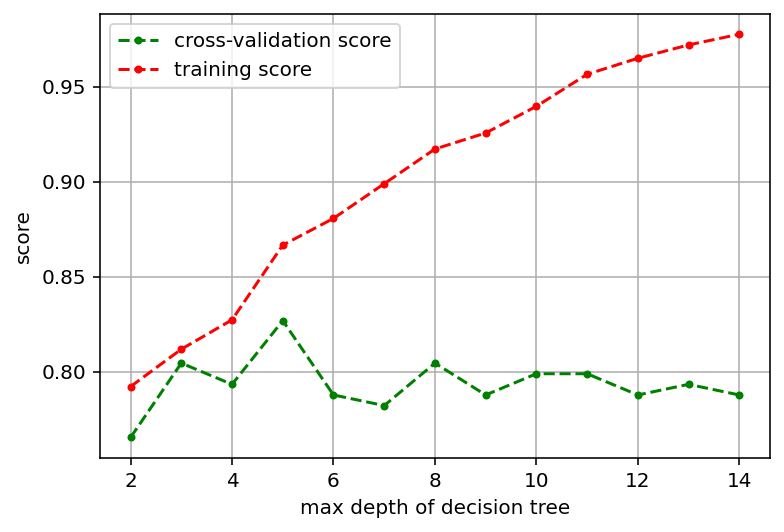

In [9]:
import matplotlib.pyplot as plt
plt.figure(figsize=(6,4), dpi=144)
plt.grid()
plt.xlabel('max depth of decision tree')
plt.ylabel('score')
plt.plot(depths, cv_scores, '.g--',label='cross-validation score')
plt.plot(depths, tr_scores, '.r--',label='training score')
plt.legend()

# 4、考察参数min_impurity_split

best param:0.01020408163265306;best score:0.8044692737430168


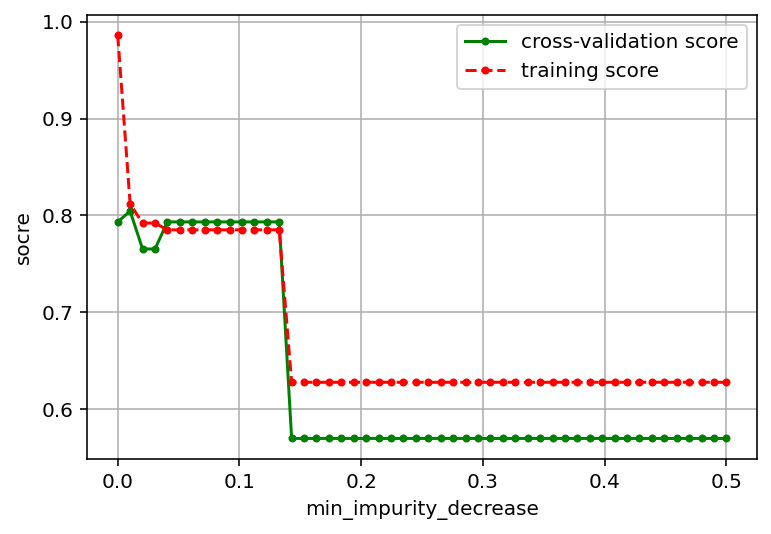

In [11]:
#训练模型并计算评分：
def cv_score(val):
    clf = DecisionTreeClassifier(criterion='gini',min_impurity_decrease=val)
    clf.fit(X_train,y_train)
    tr_score = clf.score(X_train,y_train)
    cv_score = clf.score(X_test, y_test)
    return (tr_score, cv_score)

# 指定参数范围，分别训练模型并计算评分
values = np.linspace(0, 0.5, 50)
scores = [cv_score(v) for v in values]
tr_scores = [s[0] for s in scores]
cv_scores = [s[1] for s in scores]

#找出评分最高的模型参数
best_score_index = np.argmax(cv_scores)
best_score = cv_scores[best_score_index]
best_param = values[best_score_index]
print('best param:{0};best score:{1}'.format(best_param, best_score))

#画出模型参数与模型评分的关系
plt.figure(figsize=(6,4), dpi=144)
plt.grid()
plt.xlabel('min_impurity_decrease')
plt.ylabel('socre')
plt.plot(values, cv_scores, '.g-',label='cross-validation score')
plt.plot(values, tr_scores, '.r--',label='training score')
plt.legend()

# 网格搜索

In [11]:
from sklearn.model_selection import GridSearchCV

thresholds = np.linspace(0,0.5,50)
#设置参数矩阵
param_grid = {'min_impurity_decrease':thresholds}

clf = GridSearchCV(DecisionTreeClassifier(), param_grid, cv =5)

clf.fit(X,y)

print('best param: {0}\nbest socre: {1}'.format(clf.best_params_,clf.best_score_))

best param: {'min_impurity_decrease': 0.01020408163265306}
best socre: 0.794589165777415


In [12]:
def plot_curve(train_sizes, cv_results, xlabel):
    train_scores_mean = cv_results['mean_train_score']
    train_scores_std = cv_results['std_train_score']
    test_scores_mean = cv_results['mean_test_socre']
    test_scores_std = cv_results['std_test_score']
    
    plt.figure(figsize=(6,4), dpi=144)
    plt.title('parameters turning')
    plt.grid()
    plt.xlabel(xlabel)
    plt.ylabel('score')
    
    plt.fill_between(train_sizes, 
                    train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std,
                    alpha=0.1, color='r')
    plt.fill_between(train_sizes,
                    test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std,
                    alpha=0.1, color='g')
    
    plt.legend(loc='best')
    

In [14]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
import numpy as np

# 参数范围设置
entropy_thresholds = np.linspace(0, 1, 50)
gini_thresholds = np.linspace(0, 0.5, 50)
max_depths = range(2, 10)

# 设置参数矩阵
param_grid = [
    {'criterion': ['entropy'], 'min_impurity_decrease': entropy_thresholds, 'max_depth': max_depths},
    {'criterion': ['gini'], 'min_impurity_decrease': gini_thresholds, 'max_depth': max_depths}
]

# 实例化 GridSearchCV
clf = GridSearchCV(DecisionTreeClassifier(), param_grid, cv=5)

# 训练模型并进行参数搜索
clf.fit(X, y)

# 输出最佳参数和得分
print('best param: {0}\nbest score: {1}'.format(clf.best_params_, clf.best_score_))


best param: {'criterion': 'entropy', 'max_depth': 7, 'min_impurity_decrease': 0.0}
best score: 0.8103383340656583
